# fanBase_自然语言处理

在这个notebook里面写下所有nlp子任务的一些basel medthod，ML和DL的都要有，代码越短，越简洁越好，目的在于接到任务的时候，可以快速的打下baseline，和创造pipeline

## 特征提取

### 利用本地的bert拿到词向量

In [9]:
from transformers import BertTokenizer
from tqdm import tqdm
bert_path = "D:/kwCodes/pretrained_model/chinese_roberta_wwm_ext_pytorch/"  # 该文件夹下存放三个文件（'vocab.txt', 'pytorch_model.bin', 'config.json'）
tokenizer = BertTokenizer.from_pretrained(bert_path,
                                          local_files_only=True)  # 初始化分词器
data_X = ["文[CLS]本表示成计算机能够[SEP]运算的数字或向量的方法一般称为词嵌入"]
input_ids, input_masks, input_types, = [], [], []
labels = []  # 标签
maxlen = 30  # 取30即可覆盖99%

for i, line in tqdm(enumerate(data_X)):
    title = line
    encode_dict = tokenizer.encode_plus(text=title,
                                        max_length=maxlen,
                                        padding='max_length',
                                        truncation=True)
    print(encode_dict)
    input_ids.append(encode_dict['input_ids'])
    input_types.append(encode_dict['token_type_ids'])
    input_masks.append(encode_dict['attention_mask'])

1it [00:00, 500.63it/s]

{'input_ids': [101, 3152, 101, 3315, 6134, 4850, 2768, 6369, 5050, 3322, 5543, 1916, 102, 6817, 5050, 4638, 3144, 2099, 2772, 1403, 7030, 4638, 3175, 3791, 671, 5663, 4917, 711, 6404, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


## 文本分类

### 基于bag of words和tf-idf的浅层机器学习的文本分类

文本是不定长度的。文本表示成计算机能够运算的数字或向量的方法一般称为词嵌入（Word Embedding）方法。词嵌入将不定长的文本转换到定长的空间内，是文本分类的第一步

One-hot

这里的One-hot与数据挖掘任务中的操作是一致的，即将每一个单词使用一个离散的向量表示。具体将每个字/词编码一个索引，然后根据索引进行赋值。

One-hot表示方法的例子如下：

        句子1：我 爱 北 京 天 安 门
句子2：我 喜 欢 上 海
首先对所有句子的字进行索引，即将每个字确定一个编号：

    {
        '我': 1, '爱': 2, '北': 3, '京': 4, '天': 5,
      '安': 6, '门': 7, '喜': 8, '欢': 9, '上': 10, '海': 11
    }
在这里共包括11个字，因此每个字可以转换为一个11维度稀疏向量：

    我：[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    爱：[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ...
    海：[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

Bag of Words（词袋表示），也称为Count Vectors，每个文档的字/词可以使用其出现次数来进行表示。

    句子1：我 爱 北 京 天 安 门
    句子2：我 喜 欢 上 海
直接统计每个字出现的次数，并进行赋值：

    句子1：我 爱 北 京 天 安 门
    转换为 [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]

    句子2：我 喜 欢 上 海
    转换为 [1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]

In [3]:
# 在sklearn中可以直接CountVectorizer来实现这一步骤：
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = CountVectorizer()
vectorizer.fit_transform(corpus).toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 2, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(corpus).toarray()

array([[0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524],
       [0.        , 0.6876236 , 0.        , 0.28108867, 0.        ,
        0.53864762, 0.28108867, 0.        , 0.28108867],
       [0.51184851, 0.        , 0.        , 0.26710379, 0.51184851,
        0.        , 0.26710379, 0.51184851, 0.26710379],
       [0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524]])

N-gram 与Count Vectors类似，不过加入了相邻单词组合成为新的单词，并进行计数。

如果N取值为2，则句子1和句子2就变为：

    句子1：我爱 爱北 北京 京天 天安 安门
    句子2：我喜 喜欢 欢上 上海
    
TF-IDF 分数由两部分组成：第一部分是词语频率（Term Frequency），第二部分是逆文档频率（Inverse Document Frequency）。其中计算语料库中文档总数除以含有该词语的文档数量，然后再取对数就是逆文档频率。

    TF(t)= 该词语在当前文档出现的次数 / 当前文档中词语的总数
    IDF(t)= log_e（文档总数 / 出现该词语的文档总数）
TF表示 - Fruit flies like time flies a fruit 这句话具有以下 TF 表示:[1,2,2,1,1,1,0,0]。
注意，每个条目是句子（语料库）中出现相应单词的次数的计数。我们用TF(w）表示一个单词的 TF

In [ ]:
# Count Vectors + RidgeClassifier

import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import f1_score

train_df = pd.read_csv('../data/train_set.csv', sep='\t', nrows=15000)

vectorizer = CountVectorizer(max_features=3000)
train_test = vectorizer.fit_transform(train_df['text'])

clf = RidgeClassifier()
clf.fit(train_test[:10000], train_df['label'].values[:10000])

val_pred = clf.predict(train_test[10000:])
print(f1_score(train_df['label'].values[10000:], val_pred, average='macro'))
# 0.74

In [ ]:
# TF-IDF +  RidgeClassifier

import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import f1_score

train_df = pd.read_csv('../data/train_set.csv', sep='\t', nrows=15000)

tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=3000)
train_test = tfidf.fit_transform(train_df['text'])

clf = RidgeClassifier()
clf.fit(train_test[:10000], train_df['label'].values[:10000])

val_pred = clf.predict(train_test[10000:])
print(f1_score(train_df['label'].values[10000:], val_pred, average='macro'))
# 0.87

### 基于keras与MLP的深度学习情感分析

数据预处理 = pandas+numpy

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("D:/kwCodes/REcodes/re_datasets/clothing_comment_情感分析/posdata.txt",sep="\n",header=None,names=['comment'])
df.head()

,comment
0,"质量好,做工也不错,尺码标准,"
1,裤子质量很好，裤型不错，而且穿起来显瘦，性比价高，是我喜欢的布料，不起球，值得购买，
2,做工很好，货真价实，质量不错满意！
3,真是不错呢！裤子质量很好，穿着也很有型，帅帅的，更喜欢他了呢！快递很快，态度也特别好，跟客服...
4,品质还可以，就是有点掉色，可以接受


In [4]:
df_n = pd.read_csv("D:/kwCodes/REcodes/re_datasets/clothing_comment_情感分析/negdata.txt",sep="\n",header=None,names=['comment'])
df_n.head()

,comment
0,穿上不舒服，颜色和质感跟图片差异很大，建议慎重购买！后悔了！
1,真心垃圾，以后再也不会买班尼路了
2,物流超慢，整整6天多，准备退订了才到，无语。衣服质量嘛，中下水准，穿着不太舒服。衣服穿起来的...
3,这个T恤不安逸得，和农贸市场一二十的差不多样
4,你以为是Lee那就错了，你以为会有Lee一半的品质，那就又错了，你以为会送货很快，那就又错了！


In [6]:
# 只保留汉字
import re
def rmSymbol(str):
    return re.sub("[^\u4e00-\u9fa5]",'',str)
rmSymbol("a78d679&&这是uid一个&%例子哦哦哦sahuidy^*&%^")

'这是一个例子哦哦哦'

In [7]:
# 接下来遍历评论列的每一行，过滤其中的非中文字符和长度小于1的无效评论。
from tqdm import trange
X_data_pos = []
X_data_neg = []
comments_pos = df.comment # 获取所有评论
comments_neg = df_n.comment
for i in trange(len(comments_pos)):
    comment = comments_pos.iloc[i]
    comment_n = comments_neg.iloc[i]
    try:
        comment = rmSymbol(comment)
        comment_n = rmSymbol(comment_n)
        if len(comment) > 1:
            X_data_pos.append(comment)
            X_data_neg.append(comment_n)
    except:
        pass
print(len(X_data_pos))
print(len(X_data_neg))
X_data_pos[:1],X_data_neg[:1]

100%|██████████| 1500/1500 [00:00<00:00, 38457.98it/s]

1500
1500


(['质量好做工也不错尺码标准'], ['穿上不舒服颜色和质感跟图片差异很大建议慎重购买后悔了'])

In [8]:
X_data = [i for i in X_data_pos] + [j for j in X_data_neg]
X_data[0]

'质量好做工也不错尺码标准'

In [9]:
# 得到训练数据后，我们手工创建一个labels数组存放标签，将其转换为numpy对象，便于后期输入到神经网络中
import numpy as np
y_data = [1 for i in range(1500)] + [0 for i in range(1500)]
y_data = np.asarray(y_data, dtype=np.float32)

In [10]:
# 这份数据太有规律啦，正负情感刚好前后各占一半,为了避免数据分布不规律的现象，我们需要为数据“洗牌”
X_train, y_train = [], []
nums = np.arange(3000)
print(nums[:5])
# 随机打乱12000个训练数据
np.random.shuffle(nums)
print(nums[:5])
for i in nums:
    X_train.append(X_data[i])
    y_train.append(y_data[i])
X_train[:5],y_train[:5]

[0 1 2 3 4]
[1645 1292 2992 2888 1072]


(['不满意都起毛了有点白',
  '在京东买东西就是好商品实惠还保真售后服务也挺好物流快快递员服务态度很好在京东买绝对不上当我感觉相当好在京东买东西就是好商品实惠还保真售后服务也挺好物流快快递员服务态度很好在京东买绝对不上当我感觉相当好在京东买东西就是好商品实惠还保真售后服务也挺好物流快快递员服务态度很好在京东买绝对不上当我感觉相当好',
  '产品一般和我在实体店买没啥区别',
  '穿着也不舒服感觉被忽悠了',
  '衣服收到了本来看着没多少销量会很担心质量但没想到衣服质量会这么好喜欢的不要犹豫我已经替你们试过了很百搭重要的是价格还很便宜'],
 [0.0, 1.0, 0.0, 0.0, 1.0])

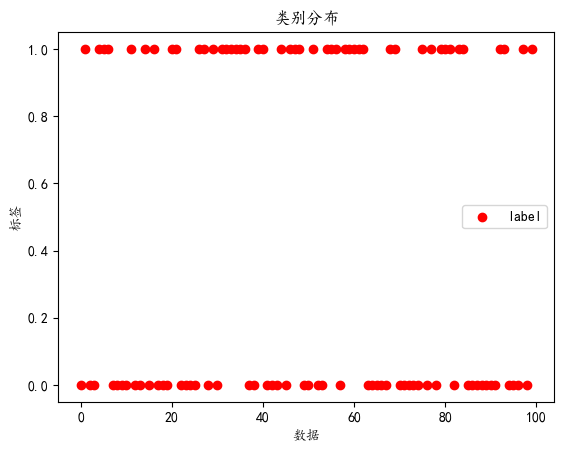

In [11]:
import matplotlib.pyplot as plt
x = range(100)
plt.rcParams['font.sans-serif'] = ['KaiTi']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
plt.scatter(x,y_train[:100], label='label',color='r')
plt.xlabel('数据')
plt.ylabel('标签')
plt.title('类别分布')
plt.legend()
plt.show()

In [15]:
maxlen = 0
for i in X_train:
    if len(i) > maxlen and len(i) != 295 and len(i) != 267:
        maxlen = len(i)
maxlen

230

获得中文词向量

In [26]:
from transformers import BertTokenizer
from tqdm import tqdm
bert_path = "D:/kwCodes/pretrained_model/chinese_roberta_wwm_ext_pytorch/"  # 该文件夹下存放三个文件（'vocab.txt', 'pytorch_model.bin', 'config.json'）
tokenizer = BertTokenizer.from_pretrained(bert_path,
                                          local_files_only=True)  # 初始化分词器
input_train = []
maxlen = 768  # 取30即可覆盖99%

for i, line in tqdm(enumerate(X_train)):
    title = line
    encode_dict = tokenizer.encode_plus(text=title,
                                        max_length=maxlen,
                                        padding='max_length',
                                        truncation=True)
#     print(encode_dict)
    input_train.append(encode_dict['input_ids'])

3000it [00:01, 2084.62it/s]


In [32]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
model = Sequential()
# 搭建模型
model.add(Dense(32, activation='relu', input_shape=(768,)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

In [33]:
input_train = np.array(input_train)
y_train = np.array(y_train)
type(input_train)

numpy.ndarray

In [ ]:
history = model.fit(
    input_train, y_train,
    epochs=60,
    batch_size=64,
    validation_split=0.2
)

In [ ]:
history_dict = history.history
history_dict

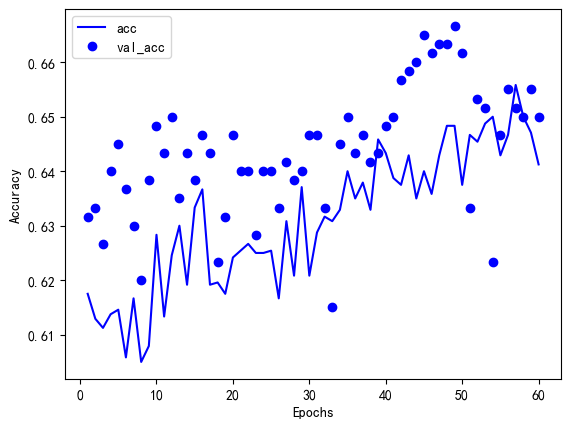

In [56]:
# 精确度编话过程
epochs = range(1, len(history_dict['acc']) + 1)
plt.figure()
plt.plot(epochs, history_dict['acc'], 'b', label='acc')
plt.plot(epochs, history_dict['val_acc'], 'bo', label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

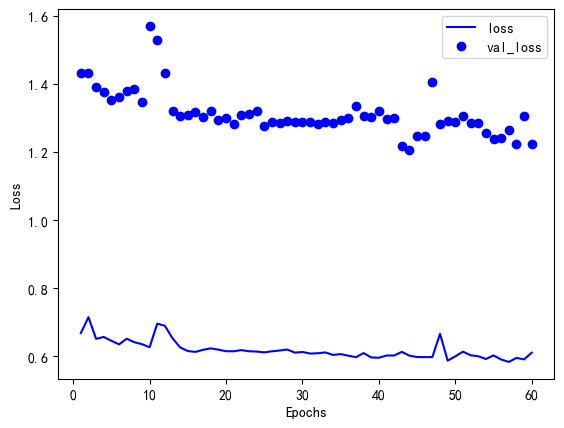

In [57]:
# 损失变化过程
plt.clf()
plt.figure()
plt.plot(epochs, history_dict['loss'], 'b', label='loss')
plt.plot(epochs, history_dict['val_loss'], 'bo', label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 调用evaluate方法测试：
test_loss = model.evaluate(
    X_test,
    y_test,
    batch_size=64,
    verbose=1
)
print(test_loss)

### 基于NLTK的机器学习文本分类与情感分析(英文)

In [6]:
# 文本分类
from nltk.text import TextCollection

text1 = 'I like the movie so much '
text2 = 'That is a good movie '
text3 = 'This is a great one '
text4 = 'That is a really bad movie '
text5 = 'This is a terrible movie'

# 构建TextCollection对象
tc = TextCollection([text1, text2, text3, 
                        text4, text5])
new_text = 'That one is a good movie. This is so good!'
word = 'That'
tf_idf_val = tc.tf_idf(word, new_text)
print('{}的TF-IDF值为：{}'.format(word, tf_idf_val))

That的TF-IDF值为：0.02181644599700369


In [ ]:
# 情感分析
# 简单的例子

import nltk
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.classify import NaiveBayesClassifier

text1 = 'I like the movie so much!'
text2 = 'That is a good movie.'
text3 = 'This is a great one.'
text4 = 'That is a really bad movie.'
text5 = 'This is a terrible movie.'

def proc_text(text):
    """
        预处处理文本
    """
    # 分词
    raw_words = nltk.word_tokenize(text)
    
    # 词形归一化
    wordnet_lematizer = WordNetLemmatizer()    
    words = [wordnet_lematizer.lemmatize(raw_word) for raw_word in raw_words]
    
    # 去除停用词
    filtered_words = [word for word in words if word not in stopwords.words('english')]
    
    # True 表示该词在文本中，为了使用nltk中的分类器
    return {word: True for word in filtered_words}

# 构造训练样本
train_data = [[proc_text(text1), 1],
              [proc_text(text2), 1],
              [proc_text(text3), 1],
              [proc_text(text4), 0],
              [proc_text(text5), 0]]

# 训练模型
nb_model = NaiveBayesClassifier.train(train_data)

# 测试模型
text6 = 'That is a good one.'
print(nb_model.classify(proc_text(text6)))

## 文本匹配

### 基于NLTK的文本相似度(英文)

In [10]:
import nltk
from nltk import FreqDist

text1 = 'I like the movie so much '
text2 = 'That is a good movie '
text3 = 'This is a great one '
text4 = 'That is a really bad movie '
text5 = 'This is a terrible movie'

text = text1 + text2 + text3 + text4 + text5
words = nltk.word_tokenize(text)
freq_dist = FreqDist(words)
print(freq_dist['is'])
print(freq_dist['so'])

# 取出常用的n=5个单词
n = 5

# 构造“常用单词列表”
most_common_words = freq_dist.most_common(n)
print(most_common_words)

def lookup_pos(most_common_words):
    """
        查找常用单词的位置
    """
    result = {}
    pos = 0
    for word in most_common_words:
        result[word[0]] = pos
        pos += 1
    return result

# 记录位置
std_pos_dict = lookup_pos(most_common_words)
print(std_pos_dict)

# 新文本
new_text = 'That one is a good movie. This is so good!'

# 初始化向量
freq_vec = [0] * n

# 分词
new_words = nltk.word_tokenize(new_text)

# 在“常用单词列表”上计算词频
for new_word in new_words:
    if new_word in list(std_pos_dict.keys()):
        freq_vec[std_pos_dict[new_word]] += 1

print(freq_vec)

4
1
[('movie', 4), ('is', 4), ('a', 4), ('That', 2), ('This', 2)]
{'movie': 0, 'is': 1, 'a': 2, 'That': 3, 'This': 4}
[1, 2, 1, 1, 1]
